In [1]:
#! pip install langchain-google-genai
#! pip install google-generativeai langgraph
#! pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
# ! pip install -U langsmith
# ! pip install -U langchain langchain-openai
# ! pip install -qU langchain-core

# ! pip install python-docx

#! pip install ipywidgets
#! jupyter nbextension enable --py widgetsnbextension --sys-prefix


In [2]:
# Step 1: Imports
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict
from IPython.display import Image, display
import os
import requests
from bs4 import BeautifulSoup
import ipywidgets as widgets

from docx import Document
from langchain_core.messages import SystemMessage, HumanMessage
import google.generativeai as genai
from langchain.tools import tool
from langgraph.prebuilt import ToolNode
import tkinter as tk
from tkinter import filedialog
import re
from dotenv import load_dotenv


In [4]:
load_dotenv()
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = os.getenv("LANGCHAIN_ENDPOINT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
api_key = os.getenv("GENAI_API_KEY")

In [6]:

class BeeState(TypedDict):
    company_url: str
    company_name: str  # Make sure this is included!
    question: str
    context: str
    answer: str
    resume: str
    messages: list  # Add if missing

In [8]:
def classify_user_intent(question: str, context: str, state: dict) -> str:
    """Use LLM to classify user intent and determine the appropriate path"""
    
    model = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash",
        google_api_key=api_key
    )
    
    classification_prompt = f"""
    You are a path classifier for a job application assistant. Based on the user's question and current state, 
    determine which path the user intends to take. Return ONLY the path name.
    
    Available paths:
    1. EXIT - User wants to quit/exit the application
    2. COVER_LETTER - User wants to generate a cover letter
    3. COMPANY_QUESTION - User has questions about the company/job
    4. CHANGE_COMPANY - User provided a company URL to change the company
    5. JOB_DESCRIPTION - User wants to know about the job.
    
    Current state:
    - Has company context: {"Yes" if context else "No"}
    - Company name: {state.get('company_name', 'Not set')}
    - Has resume: {"Yes" if state.get('resume') else "No"}
    
    User question: "{question}"
    
    Based on the above information, what is the user's primary intent?
    Return only one of: EXIT, COVER_LETTER, COMPANY_QUESTION, URL_PROCESSING, RESUME_TOOLS, GENERAL_ASSISTANCE
    """
    
    response = model.invoke([HumanMessage(content=classification_prompt)])
    intent = response.content.strip().upper()
    
    # Fallback validation
    valid_intents = ["EXIT", "COVER_LETTER", "COMPANY_QUESTION", "URL_PROCESSING", "RESUME_TOOLS", "GENERAL_ASSISTANCE", "JOB_DESCRIPTION"]
    if intent not in valid_intents:
        return "GENERAL_ASSISTANCE"  # Safe fallback
    
    return intent



In [10]:
def agent_node(state: BeeState):
    """LLM agent that can: 1) Use tools, 2) Write cover letters, 3) Answer company questions"""
    
    tools = [
        parse_resume_tool,
        update_resume_context,
        # Remove parse_question_for_company_info from tools since we're handling URLs directly
    ]
    
    question = state.get("question", "").lower()
    context = state.get("context", "")
    intent = classify_user_intent(question, context, state)
    print(f"Classified intent: {intent}")
    # PATH 1: User wants cover letter AND we have context

    if intent == "EXIT":
        # Ask for confirmation
        confirm = input("Are you sure you want to exit? (y/n): ").lower()
        if confirm in ["y", "yes"]:
            
            return {**state, "question": "exit", "answer": "Goodbye! Your session data has been saved.!"}
        else:
            return {
                **state,
                "question": "Continue",
                "answer": "Continuing session..."
            }
            
    elif intent == "COVER_LETTER":
        model = ChatGoogleGenerativeAI(
            model="gemini-1.5-flash",
            google_api_key=api_key
        )  # No tools - just generate
        job_title = input("What job is this for? ")
        messages = [
            SystemMessage(content="You are a helpful assistant that writes compelling, personalized cover letters. When making the cover letter, be sure to pull information that the person has done from their resume in order. For example, pull projects or skills they might have that have high correaltion to the job title. Also put a random number from 1- 100 at the top"),
            HumanMessage(content=f"""
            Write a personalized cover letter for:
            Job: {job_title}
            Company Name: {state['company_name']}
            Resume : {state['resume']}
            Context: {context}
            and make sure to add any comments such as tone or formality noted in this {state['question']}
            """)
        ]
        #print("Pre_invoke")
        response = model.invoke(messages)
        #print("Post_invoke")
        #print(response.content)
        return {
            **state,
            "answer": response.content,
            "messages": state.get("messages", []) + [response]
        }
    
    # PATH 2: User has questions about company/job AND we have context  
    elif intent == "COMPANY_QUESTION":
        model = ChatGoogleGenerativeAI(
            model="gemini-1.5-flash",
            google_api_key=api_key
        )  # No tools - just answer
        
        messages = [
            SystemMessage(content="You are a helpful assistant. Answer questions based on the provided context."),
            HumanMessage(content=f"""
            Context: {context}
            
            Question: {state['question']}
            """)
        ]
        
        response = model.invoke(messages)
        #print(response.content)
        return {
            **state,
            "answer": response.content,
            "messages": state.get("messages", []) + [response]
        }
    
    # PATH 3: Direct URL processing - handle company URLs without tools
    elif intent == "CHANGE_COMPANY":
        print("URL detected in question - processing company website")
        
        # Extract URL from the question
        url = extract_url_from_text(state.get("question", ""))
        
        try:
            print("Extracting company information...")
            
            # Extract company name
            extracted_name = extract_company_name_from_website(url)
            print(f"Detected company name: {extracted_name}")
            
            # Get company name confirmation
            if not extracted_name or extracted_name.strip() == "":
                company_name = input("Could not detect company name. Please enter the company name: ").strip()
            else:
                confirmation = input(f"Is '{extracted_name}' the correct company name? (y/n): ").strip().lower()
                if confirmation not in ["y", "yes"]:
                    company_name = input("Please enter the correct company name: ").strip()
                else:
                    company_name = extracted_name
            
            print(f"Using company name: {company_name}")
            
            # Parse company website for information
            company_info = parse_company_website(url, company_name)
            print("Successfully extracted company info")
            
            # Replace the old context with new company info
            new_context = company_info  # Replace completely instead of appending
            #print(f"Successfully updated company to {company_name}. Company information has been extracted and is ready for cover letters or questions!")
            return {
                **state,
                "company_name": company_name,
                "company_url": url,
                "context": new_context,  # This replaces the old context
                
                "answer": f"Successfully updated company to {company_name}. Company information has been extracted and is ready for cover letters or questions!"
            }
            
        except Exception as e:
            company_name = locals().get('company_name', 'Unknown')
            print(f"Had trouble extracting complete info from {url}, but set company to {company_name}. Error: {str(e)}")
            return {
                **state,
                "company_name": company_name,
                "company_url": url,
                "context": f"Company Name: {company_name}\nCompany Info: Error - {str(e)}",
                
                "answer": f"Had trouble extracting complete info from {url}, but set company to {company_name}. Error: {str(e)}"
            }
    elif intent == "JOB_DESCRIPTION":
        print("URL detected in question - processing job position")
        company_name = input("Please enter the url for the job description: ").strip()
        # Extract URL from the question
        url = extract_url_from_text(company_name)
        
        try:
            print("Extracting company information...")
            
            # Extract company name
            extracted_name = extract_company_name_from_website(url)
            
            
            print(f"Using company name: {company_name}")
            
            # Parse company website for information
            company_info = parse_company_website(url, company_name)
            print("Successfully extracted company info")
            
            # Replace the old context with new company info
            new_context = company_info  # Replace completely instead of appending
            model = ChatGoogleGenerativeAI(
                model="gemini-1.5-flash",
                google_api_key=api_key
            )  # No tools - just answer
            
            messages = [
                SystemMessage(content="You are a helpful assistant. You are to provide advice on the job position. This could range from job experinece, keywords, and other important aspects of the job"),
                HumanMessage(content=f"""
                Context: {new_context}
                
                Question: {state['question']}
                """)
            ]
        
            response = model.invoke(messages)
            return {
                "answer": response.content,
                "messages": state.get("messages", []) + [response]
            }
            
        except Exception as e:
            company_name = locals().get('company_name', 'Unknown')
            print(f"Had trouble extracting complete info from {url}, but set company to {company_name}. Error: {str(e)}")
            return {
                **state,
                "company_name": company_name,
                "company_url": url,
                "context": f"Company Name: {company_name}\nCompany Info: Error - {str(e)}",
                
                "answer": f"Had trouble extracting complete info from {url}, but set company to {company_name}. Error: {str(e)}"
            }
    # PATH 4: User wants to use tools (resume changes, etc.) OR general assistance
    else:
        model = ChatGoogleGenerativeAI(
            model="gemini-1.5-flash",
            google_api_key=api_key
        ).bind_tools(tools)  # Only resume-related tools now
        
        system_prompt = """You are a job application assistant. You can:
        - Parse resume files (if user wants to change/update resume)
        - Update resume information
        - Answer questions and provide guidance
        
        If the user mentions changing, updating, or using a different resume, use the resume parsing tools.
        If you don't have enough information to help them, let them know what you need.
        
        Note: Company URL processing is handled separately, so focus on resume tasks and general assistance."""
        #took out Job: {state['job_title']}
        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=f"""
            
            Company: {state.get('company_name', state.get('company_url', 'Not set'))}
            Current context: {context or 'None available'}
            User request: {state['question']}
            """)
        ]
        
        # Only add existing messages from state
        if state.get("messages"):
            messages.extend(state["messages"])
        
        response = model.invoke(messages)
        #print("Tool was just used")
        return {
            **state,
            "answer": "Tool was just used",
            "messages": state.get("messages", []) + [response]
        }


In [12]:
@tool
def parse_resume_tool(file_path: str) -> str:
    """Parse a resume file and extract relevant information for job applications."""
    try:
        # Your existing resume parsing logic
        resume_data = parse_resume_and_prompt_job(file_path)  # Your existing function
        return f"Resume parsed successfully: {resume_data}"
    except Exception as e:
        return f"Error parsing resume: {str(e)}"

@tool
def update_resume_context(new_resume_data: str) -> str:
    """Update the current resume information with new data."""
    return f"Resume context updated with: {new_resume_data}"




In [14]:

@tool

def parse_question_for_company_info(company_url: str) -> str:
    """If the user gives a URL, this extracts company info and returns company information.
    
    Args:
        company_url: The URL of the company website to parse
    """
    print("extracting tool is happening")
    url = company_url.strip()
    if not url:
        raise ValueError("No company URL provided")
    
    # Step 1: Try to extract the company name
    extracted_name = extract_company_name_from_website(url)
    print(f"Detected company name: {extracted_name}")
    
    # Step 2: Confirm or override the company name
    confirmation = input(f"Is '{extracted_name}' the correct company namea? (y/n): ").strip().lower()
    if confirmation not in ["y", "yes"]:
        company_name = input("Please enter the correct company name: ").strip()
    else:
        company_name = extracted_name
    
    print(f"Using company name: {company_name}")
    
    # Step 3: Try to parse the company website for info
    try:
        company_info = parse_company_website(url, company_name)
        return f"Successfully updated company to {company_name}. Company info: {company_info}"
    except Exception as e:
        return f"Changed company to {company_name}, but failed to retrieve full company info. Error: {str(e)}"


def extract_company_info_from_url(state: BeeState) -> BeeState:
    """Updated function that extracts company name with user confirmation"""
    print("Extract Company just ran")
    url = state.get("company_url", "").strip()
    company_name = state.get("company_name", "")
    print(company_name, url)
    
    # If no company name provided, try to extract it from the URL/website
    if not company_name:
        extracted_name = extract_company_name_from_website(url)
        
        if extracted_name:
            print(f"Detected company name: {extracted_name}")
            confirmation = input("Is this the correct company name? (y/n): ").strip().lower()
            
            if confirmation in ['y', 'yes']:
                company_name = extracted_name
            else:
                company_name = input("Please enter the correct company name: ").strip()
        else:
            # Couldn't extract, ask directly
            company_name = input("Please enter the company name: ").strip()
    
    print(f"Using company name: {company_name}")
    
    try:
        # Use the tool to parse the website
        company_info = parse_company_website(url, company_name)
        new_context = state.get("context", "") + "\n\n" + company_info
        print(new_context)
        return {
            **state,
            "company_name": company_name,
            "context": new_context
            
        }
    except Exception as e:
        return {
            **state,
            "company_name": company_name,
            "context": state.get("context", "") + f"\n\nCompany Name: {company_name}\nCompany Info: Unknown (Error: {str(e)})"
            
        }

def extract_company_name_from_website(url: str) -> str:
    """Extract company name from website content, fallback to domain"""
    try:
        if not url.startswith("http"):
            url = "https://" + url
            
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        
        company_name = ""
        
        # 1. Check og:site_name meta tag
        og_site = soup.find("meta", attrs={"property": "og:site_name"})
        if og_site:
            company_name = og_site.get("content", "").strip()
        
        # 2. Check title tag (remove common suffixes)
        if not company_name and soup.title:
            title = soup.title.string.strip()
            # Remove common suffixes
            title = re.sub(r'\s*[-|–]\s*(Home|About|Welcome|Official Site|Jobs|Careers).*$', '', title, flags=re.IGNORECASE)
            company_name = title
        
        # 3. Fallback to domain extraction
        if not company_name:
            parsed = urlparse(url)
            domain = parsed.netloc.lower()
            
            # Handle subdomains
            if domain.count('.') >= 2:
                parts = domain.split('.')
                if parts[0] in ['careers', 'blog', 'support', 'www', 'jobs', 'about']:
                    domain = '.'.join(parts[1:])
            
            # Remove www. and TLDs
            domain = re.sub(r'^www\.', '', domain)
            domain = re.sub(r'\.(com|org|net|edu|gov|io|co\.uk|co|ai|ly|me)$', '', domain)
            
            # Handle common prefixes
            domain = re.sub(r'^(try|get|join|go|use)', '', domain)
            
            # Convert hyphens to spaces and title case
            if '-' in domain or '_' in domain:
                company_name = re.sub(r'[-_]', ' ', domain).title()
            else:
                company_name = domain.capitalize()
            
        return company_name
        
    except Exception:
        return ""

def parse_company_website(url: str, company_name: str) -> str:
    """
    Parses the company's website to extract a short description or summary.

    Args:
        url (str): The URL of the company's website.
        company_name (str): The name of the company.

    Returns:
        str: Extracted company information or a short description.
    """
    if not url.startswith("http"):
        url = "https://" + url

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        raise RuntimeError(f"Failed to retrieve website: {e}")

    soup = BeautifulSoup(response.text, 'html.parser')

    # Try common meta tags first
    description = ""
    if soup.find("meta", attrs={"name": "description"}):
        description = soup.find("meta", attrs={"name": "description"}).get("content", "")
    elif soup.find("meta", attrs={"property": "og:description"}):
        description = soup.find("meta", attrs={"property": "og:description"}).get("content", "")
    elif soup.title:
        description = soup.title.string.strip()

    # Fallback to grabbing the first paragraph
    if not description:
        p_tag = soup.find("p")
        if p_tag:
            description = p_tag.get_text(strip=True)

    if not description:
        raise RuntimeError("Could not extract description from website.")

    return f"Company Name: {company_name}\nWebsite: {url}\nDescription: {description}"


In [16]:
def contains_url(text):
        url_pattern = r'https?://[^\s]+'
        return bool(re.search(url_pattern, text))

In [18]:
def final_output_node(state: BeeState):
    """Output the final response or tool usage"""
    print(state["answer"])

    return state

In [20]:
def resume_check_node(state: BeeState) -> BeeState:
    """Node that passes through state unchanged"""
    print("This is resume_check_node - just passing through")
    return {**state}  # Return the state unchanged

In [22]:
def resume_condition(state: BeeState) -> str:
    """Check if resume is already parsed and saved in state"""
    print(f"Checking resume. Current resume length: {len(state.get('resume', ''))}")
    if state.get("resume"):  # Check if resume field has content
        print("Resume exists - going to llm_selector")
        return "question_input"  # Skip resume parsing
    else:
        print("No resume - going to resume_parser")
        return "resume_parser"  # Need to parse resume

In [24]:


def browse_for_resume():
    root = tk.Tk()
    root.withdraw()  # Hide the empty window
    file_path = filedialog.askopenfilename(
        title="Select your resume",
        filetypes=[("Word Documents", "*.docx")]
    )
    if not file_path:
        print("No file selected.")
        return None
    return file_path

def parse_resume_and_prompt_job(state: dict) -> dict:
    file_path = browse_for_resume()
    if not file_path:
        raise ValueError("No resume file selected.")

    try:
        doc = Document(file_path)
        paragraphs = [p.text for p in doc.paragraphs if p.text.strip()]
        resume_text = "\n".join(paragraphs)
    except Exception as e:
        print(f"Error reading resume: {e}")
        resume_text = "Experienced professional with background in software engineering."
    

    return {
        **state,
        #"job_title": job_title,
        "resume": resume_text
        #is there a reason for this
        #"context": resume_context + "\n\n" + state.get("context", ""),
        
    }

# Example test run:


In [26]:
# Extract URL from question if present
def extract_url_from_text(text):
    url_pattern = r'https?://[^\s]+'
    match = re.search(url_pattern, text)
    return match.group(0) if match else None

In [29]:
def question_input_node(state: BeeState) -> BeeState:
    """Collect user's question/request"""
    question = input("What would you like me to help with? (e.g., 'write cover letter', 'tell me about the company'): ")
    print(f"User entered: '{question}'")
    return {
        **state,
        "question": question  # This gets passed to agent_node
    }

In [31]:
def should_continue_conversation(state: BeeState) -> str:
        question = state.get("question", "").lower()
        if question in ['exit', 'quit', 'stop']:
            return "end"
        return "continue"

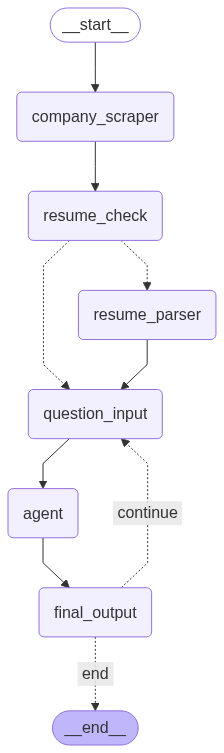

In [33]:
checkpointer = MemorySaver()


# Create tool node
tool_node = ToolNode([
    parse_resume_tool,      
    update_resume_context
])

graph = StateGraph(BeeState)


graph.add_node("company_scraper", extract_company_info_from_url)
graph.add_node("resume_check", resume_check_node)
graph.add_node("resume_parser", parse_resume_and_prompt_job)  
graph.add_node("question_input", question_input_node)
graph.add_node("agent", agent_node)                  

graph.add_node("final_output", final_output_node)

graph.set_entry_point("company_scraper")

# Flow: company_scraper → resume_check
graph.add_edge("company_scraper", "resume_check")

graph.add_conditional_edges(
    "resume_check",
    resume_condition,
    {
        "resume_parser": "resume_parser",    
        "question_input": "question_input"   
    }
)
graph.add_conditional_edges(
        "final_output",
        should_continue_conversation,
        {
            "continue": "question_input",  # Back to agent for new question
            "end": END
        }
    )

graph.add_edge("resume_parser", "question_input")
graph.add_edge("question_input", "agent")

# Agent decision
graph.add_edge("agent", "final_output")
compiled = graph.compile(checkpointer=checkpointer)
display(Image(compiled.get_graph().draw_mermaid_png()))


In [ ]:
initial_state = {
    "job_title": "",
    "company_url": input("Enter the company URL: "),
    #"company_url": "https://www.nvidia.com/en-us/",
    "context": "",
    "answer": "",
}



config = {"configurable": {"thread_id": "conversation_2"}}

result = compiled.invoke(initial_state, config=config)

# https://nvidia.wd5.myworkdayjobs.com/en-US/NVIDIAExternalCareerSite/job/US-CA-Santa-Clara/Algorithm-Engineer_JR1999152
# https://www.nvidia.com/en-us/
# https://redditinc.com

Enter the company URL:  https://www.nvidia.com/en-us/


Extract Company just ran
 https://www.nvidia.com/en-us/
Detected company name: NVIDIA


Is this the correct company name? (y/n):  y


Using company name: NVIDIA


Company Name: NVIDIA
Website: https://www.nvidia.com/en-us/
Description: NVIDIA invents the GPU and drives advances in AI, HPC, gaming, creative design, autonomous vehicles, and robotics.
This is resume_check_node - just passing through
Checking resume. Current resume length: 0
No resume - going to resume_parser


2025-08-13 17:08:18.227 python[48665:3533507] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


What would you like me to help with? (e.g., 'write cover letter', 'tell me about the company'):  I want to know about a job title


User entered: 'I want to know about a job title'
Classified intent: JOB_DESCRIPTION
URL detected in question - processing job position


Please enter the url for the job description:  https://nvidia.wd5.myworkdayjobs.com/en-US/NVIDIAExternalCareerSite/job/US-CA-Santa-Clara/Algorithm-Engineer_JR1999152


Extracting company information...
Using company name: https://nvidia.wd5.myworkdayjobs.com/en-US/NVIDIAExternalCareerSite/job/US-CA-Santa-Clara/Algorithm-Engineer_JR1999152
Successfully extracted company info
The job title is **Algorithm Engineer**.  This role focuses on developing and refining algorithms for autonomous driving systems, specifically working with 3D world models, map and perception data integration, and enhancing scenario understanding for self-driving vehicles.  The position requires significant experience in software development and a strong understanding of relevant algorithms and technologies.


In [ ]:
#https://aws.amazon.com